# Jakub Kasperski

# Lab 4: Model-Based Offline Optimization

In this lab, we explore **Model-Based Offline Optimization (MBO)**, a method to optimize black-box functions using only a pre-collected dataset, without additional function evaluations. We'll use two functions from the **Black-Box Optimization Benchmarking (BBOB)** suite:
- **f1** [Sphere Function](https://numbbo.github.io/gforge/downloads/download16.00/bbobdocfunctions.pdf#page=5): A simple, unimodal function with a global minimum at (0, 0).
- **f22** [Gallagher's Gaussian 21-hi Peaks Function](https://numbbo.github.io/gforge/downloads/download16.00/bbobdocfunctions.pdf#page=110): A complex, multimodal function with many local optima.

Visualizations of these problems are available [here](https://coco-platform.org/testsuites/bbob/viz.html?col=3&dim=2&fun=1&ins=1&typ=all).

### Objectives
1. **Dataset:** Use pre-collected datasets (100k samples each) for f1 and f22, generated via **Latin Hypercube Sampling (LHS)** [learn more about LHS here](https://en.wikipedia.org/wiki/Latin_hypercube_sampling).
2. **Surrogate Model:** Train a Multi-Layer Perceptron (MLP) to approximate these functions.
3. **Visualization:** Compare the MLP's predictions to the true functions using contour and scatter plots.
4. **Optimization:** Implement gradient-based optimization on the MLP to find optimal points.
5. **Experiments:** Investigate how training dataset size and model complexity affect performance.

### Key Concepts
- **Offline Optimization:** No new evaluations of the true function are allowed; we rely solely on the dataset.
- **Surrogate Model:** The MLP acts as a cheap, differentiable proxy for the expensive black-box function.
- **Gradient-Based Optimization:** Use the MLP's gradients to find optimal designs efficiently.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd

device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

In [2]:
device

device(type='cuda')

### 1. Data Preparation

We start by loading and splitting the dataset into training, validation, and test sets.

In [3]:
def prepare_dataloaders(
    file_path: str,
    batch_size: int = 256,
    train_perc: float = 0.6,
    val_perc: float = 0.2,
) -> tuple[DataLoader, DataLoader, DataLoader]:
    """
    Prepare train, validation and test dataloaders.

    Args:
        file_path: Path to CSV data file
        batch_size: Batch size for dataloaders
        train_perc: Percentage of data for training
        val_perc: Percentage of data for validation
    """
    # Load data
    data_df = pd.read_csv(file_path)
    X = torch.tensor(data_df[["x1", "x2"]].values, dtype=torch.float32)
    y = torch.tensor(data_df["y"].values.reshape(-1, 1), dtype=torch.float32)

    # Split data
    num_samples = len(X)
    indices = np.random.permutation(num_samples)
    train_size = int(train_perc * num_samples)
    val_size = int(val_perc * num_samples)

    # Create datasets
    train_dataset = TensorDataset(X[indices[:train_size]], y[indices[:train_size]])
    val_dataset = TensorDataset(
        X[indices[train_size : train_size + val_size]],
        y[indices[train_size : train_size + val_size]],
    )
    test_dataset = TensorDataset(
        X[indices[train_size + val_size :]], y[indices[train_size + val_size :]]
    )

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, persistent_workers=True, num_workers=4, pin_memory=True, prefetch_factor=2)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, persistent_workers=True, num_workers=4, pin_memory=True, prefetch_factor=2)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, persistent_workers=True, num_workers=4, pin_memory=True, prefetch_factor=2)

    return train_dataloader, val_dataloader, test_dataloader

# Example usage (replace with your file path)
train_dataloader, val_dataloader, test_dataloader = prepare_dataloaders(
    "./bbob_f022_i01_d02_samples.csv", train_perc=0.3, val_perc=0.4
)

### 2. Define the MLP Model

The MLP will serve as our surrogate model to approximate the black-box function.

In [4]:
class MLP(nn.Module):
    def __init__(
        self, input_dim: int = 2, hidden_dim: int = 256, n_layers: int = 3
    ) -> None:
        """
        Multi-Layer Perceptron (MLP) for function approximation.

        Args:
            input_dim (int): Number of input features (e.g., 2 for x1, x2).
            hidden_dim (int): Number of neurons in each hidden layer.
            n_layers (int): Total number of layers (input + hidden + output).
        """
        super(MLP, self).__init__()

        layers = []
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())

        # Hidden layers
        for _ in range(n_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        # Output layer -> 1 output neuron (regression, single-objective problem)
        layers.append(nn.Linear(hidden_dim, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

### 3. Training the Model

We train the MLP using the Adam optimizer and Mean Squared Error (MSE) loss.

In [28]:
model = MLP().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, targets in train_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss = train_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss = val_loss / len(val_dataloader.dataset)
    val_losses.append(val_loss)
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)

test_loss = test_loss / len(test_dataloader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Epoch 10/100, Train Loss: 406.2028, Val Loss: 399.3611
Epoch 20/100, Train Loss: 279.2951, Val Loss: 275.2440
Epoch 30/100, Train Loss: 214.2909, Val Loss: 216.6438
Epoch 40/100, Train Loss: 176.1511, Val Loss: 175.1123
Epoch 50/100, Train Loss: 153.9537, Val Loss: 152.8345
Epoch 60/100, Train Loss: 141.1040, Val Loss: 140.4519
Epoch 70/100, Train Loss: 131.4333, Val Loss: 138.8444
Epoch 80/100, Train Loss: 119.1562, Val Loss: 124.5574
Epoch 90/100, Train Loss: 112.5750, Val Loss: 113.8084
Epoch 100/100, Train Loss: 107.8307, Val Loss: 108.9927
Test Loss: 106.8437


### 4. Visualization

Let's visualize how well the MLP approximates the true function.

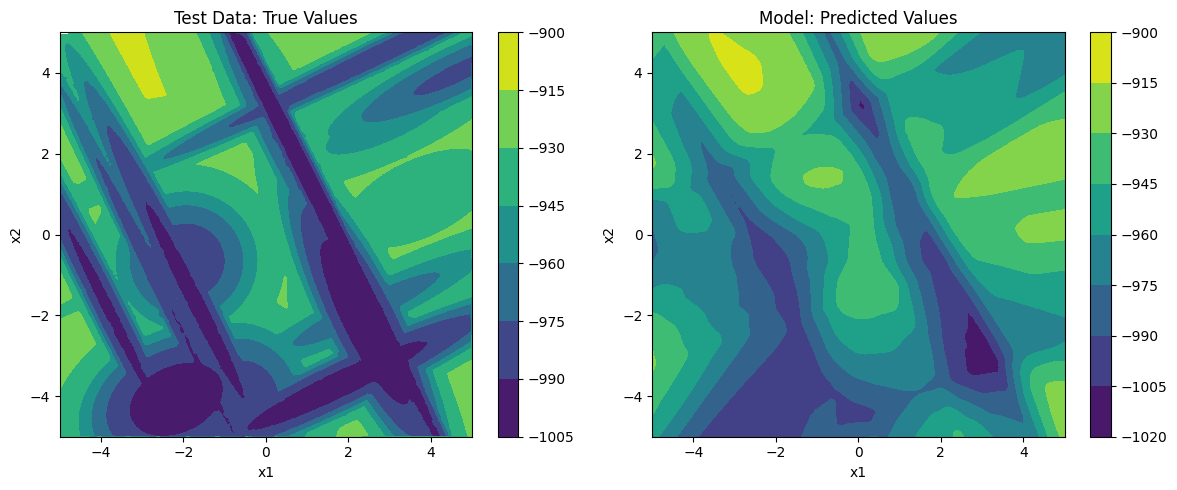

In [53]:
def plot_contour_comparison(
    model: nn.Module, test_dataloader: DataLoader, device: torch.device, predicted_x = None
) -> None:
    test_inputs_list = []
    test_targets_list = []

    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        test_inputs_list.append(inputs.cpu().numpy())
        test_targets_list.append(targets.cpu().numpy())

    test_inputs = np.vstack(test_inputs_list)
    test_targets = np.concatenate(test_targets_list)

    x1_min, x1_max = test_inputs[:, 0].min(), test_inputs[:, 0].max()
    x2_min, x2_max = test_inputs[:, 1].min(), test_inputs[:, 1].max()
    x1_vals = np.linspace(x1_min, x1_max, 100)
    x2_vals = np.linspace(x2_min, x2_max, 100)
    X1, X2 = np.meshgrid(x1_vals, x2_vals)

    grid_points = np.column_stack((X1.flatten(), X2.flatten()))
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32, device=device)

    model.eval()
    with torch.no_grad():
        predictions = model(grid_tensor).cpu().numpy().flatten()

    Z_pred = predictions.reshape(X1.shape)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    true_contour = ax1.tricontourf(
        test_inputs[:, 0], test_inputs[:, 1], test_targets.reshape(-1)
    )
    ax1.set_title("Test Data: True Values")
    ax1.set_xlabel("x1")
    ax1.set_ylabel("x2")
    plt.colorbar(true_contour, ax=ax1)
    

    pred_contour = ax2.contourf(X1, X2, Z_pred)
    ax2.set_title("Model: Predicted Values")
    ax2.set_xlabel("x1")
    ax2.set_ylabel("x2")
    plt.colorbar(pred_contour, ax=ax2)
    
    if predicted_x is not None:
        x_points = np.array([x.cpu().detach().numpy().flatten() for x in x_tab])
        
        ax1.scatter(x_points[:, 0], x_points[:, 1], color="red", s=50)
        ax2.scatter(x_points[:, 0], x_points[:, 1], color="red", s=50)

    plt.tight_layout()
    plt.show()

plot_contour_comparison(model, test_dataloader, device)

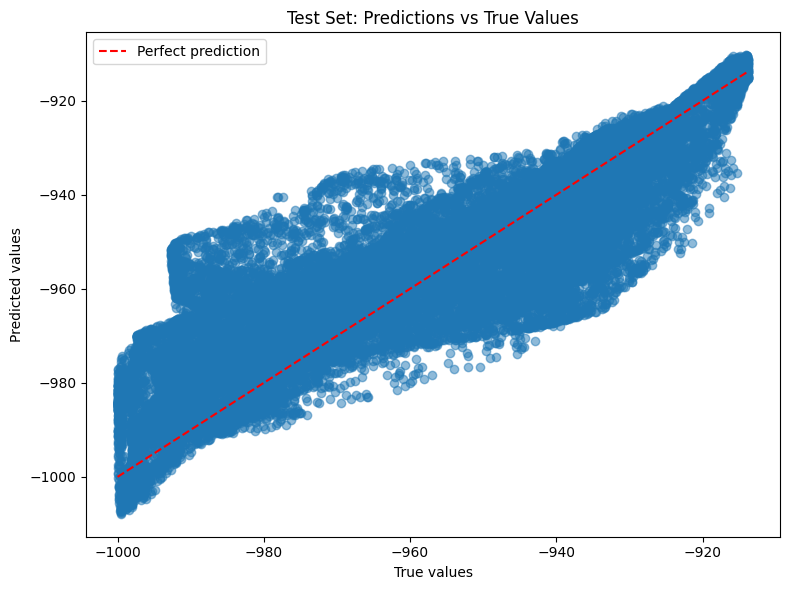

In [13]:
def plot_prediction_scatter(
    model: nn.Module, test_dataloader: DataLoader, device: torch.device
) -> None:
    test_targets_list = []
    test_preds_list = []

    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            outputs = model(inputs)

        test_targets_list.append(targets.cpu().numpy())
        test_preds_list.append(outputs.cpu().numpy())

    test_targets = np.concatenate(test_targets_list)
    test_preds = np.concatenate(test_preds_list).flatten()

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(test_targets, test_preds, alpha=0.5)
    ax.plot(
        [test_targets.min(), test_targets.max()],
        [test_targets.min(), test_targets.max()],
        "r--",
        label="Perfect prediction",
    )
    ax.set_xlabel("True values")
    ax.set_ylabel("Predicted values")
    ax.set_title("Test Set: Predictions vs True Values")
    ax.legend()

    plt.tight_layout()
    plt.show()


plot_prediction_scatter(model, test_dataloader, device)

### 5. Gradient-Based Optimization

Now, we optimize the trained MLP to find the input that minimizes its output (our surrogate's prediction).

In [37]:
def optimize_model(
    model: nn.Module, num_steps: int = 1000
) -> tuple[torch.Tensor, float]:
    """
    Perform gradient-based optimization on the MLP.

    Args:
        model (nn.Module): Trained MLP model.
        num_steps (int): Number of optimization steps.

    Returns:
        tuple: (best_x, best_y) - Optimal input and its predicted output.
    """
    model.eval()
    # Select random starting point in [-5, 5]^2
    x = torch.rand(1, 2, device=device) * 10 - 5
    x.requires_grad_(True)

    best_x = x.clone().detach() 
    best_y = float("inf")

    optimizer = torch.optim.Adam([x], lr=0.001)

    for _ in range(num_steps):
        optimizer.zero_grad()
        # Predict output (our output - result of the model is the function we want to minimize)
        output = model(x)
        # Compute gradients (gradients of our model)
        output.backward()
        # Update x
        if output < best_y:
            best_x = x.clone().detach() 
            best_y = output.item()

        optimizer.step()

        # Enforce domain constraints [-5, 5]
        with torch.no_grad():
            x.clamp_(-5, 5)

    return best_x, best_y

### Exercise 1: Impact of Dataset Size
- **Task:** Train the MLP with different training set sizes (e.g., 100, 1000, 5000, 10000, 50000).
- **Instructions:**
  1. Modify the `train_perc` parameter in `prepare_dataloaders` to achieve these different dataset sizes (keep the test set size fixed at approximately 30,000 samples).
  2. Train the model for each dataset size and generate corresponding contour plots.
  3. Analyze how the MLP's ability to capture the underlying function structure (particularly the multimodal nature of f22) improves with increasing data volume.
  4. Select and justify a single quantitative metric that effectively captures the model’s predictive quality in this context. Use this metric to evaluate model performance across different training set sizes. Present the results as a plot to visualize how model quality scales with data availability.

In [15]:
dataset_size = 256 * (len(train_dataloader) + len(val_dataloader) + len(test_dataloader))
train_set_sizes = [100, 1000, 5000, 10000, 50000]
test_perc = 0.7

Train set size: 256
Valid set size: 70144
Test set size: 30208
Epoch 10/100, Train Loss: 902064.5625, Val Loss: 904632.7248
Epoch 20/100, Train Loss: 876326.8125, Val Loss: 878252.8993
Epoch 30/100, Train Loss: 836433.1250, Val Loss: 837752.4356
Epoch 40/100, Train Loss: 779172.7500, Val Loss: 780093.0862
Epoch 50/100, Train Loss: 702611.8750, Val Loss: 703588.6514
Epoch 60/100, Train Loss: 607337.1250, Val Loss: 609068.2299
Epoch 70/100, Train Loss: 497378.7500, Val Loss: 500706.0085
Epoch 80/100, Train Loss: 380941.9688, Val Loss: 386706.2477
Epoch 90/100, Train Loss: 270291.3438, Val Loss: 279037.7486
Epoch 100/100, Train Loss: 179249.1719, Val Loss: 190895.3788
Test Loss (MSE): 190890.5643
Test Loss2 (MAE): 392.2917


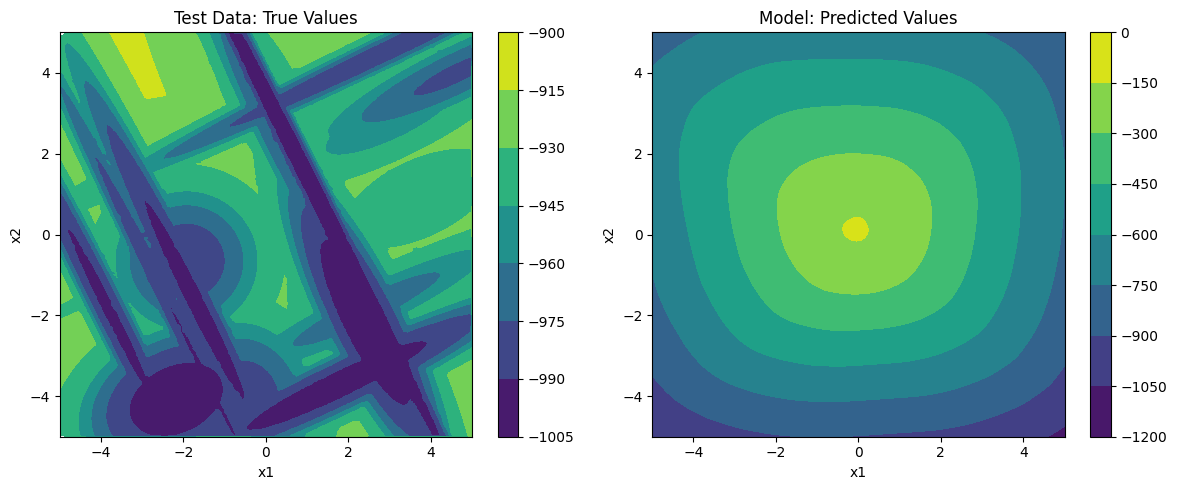

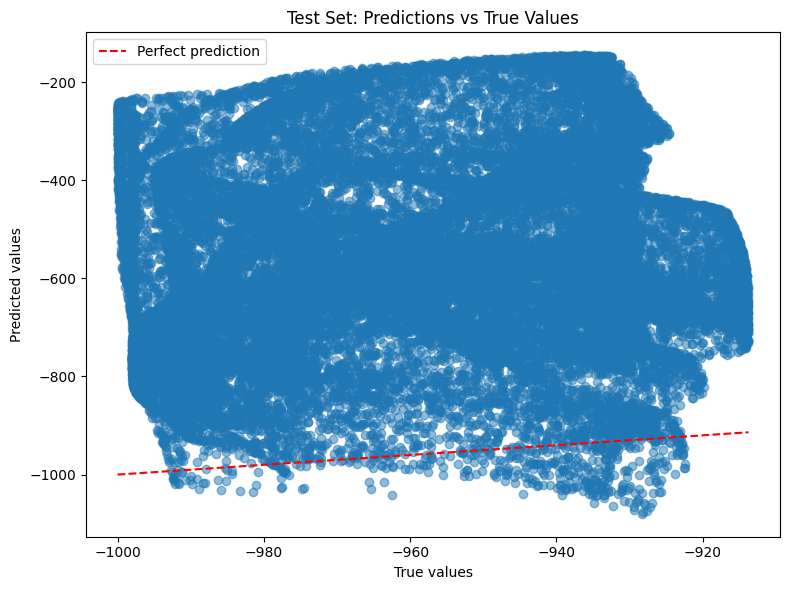

Train set size: 1024
Valid set size: 69120
Test set size: 30208
Epoch 10/100, Train Loss: 780901.7173, Val Loss: 761104.7442
Epoch 20/100, Train Loss: 374908.8895, Val Loss: 340939.1479
Epoch 30/100, Train Loss: 93768.4623, Val Loss: 85710.3617
Epoch 40/100, Train Loss: 81453.1532, Val Loss: 76758.8928
Epoch 50/100, Train Loss: 76786.7470, Val Loss: 72355.6079
Epoch 60/100, Train Loss: 72043.8637, Val Loss: 67906.4869
Epoch 70/100, Train Loss: 67040.6194, Val Loss: 63196.5990
Epoch 80/100, Train Loss: 61788.3597, Val Loss: 58232.2745
Epoch 90/100, Train Loss: 56254.2128, Val Loss: 52996.6800
Epoch 100/100, Train Loss: 50516.8260, Val Loss: 47567.2032
Test Loss (MSE): 48176.3001
Test Loss2 (MAE): 180.0795


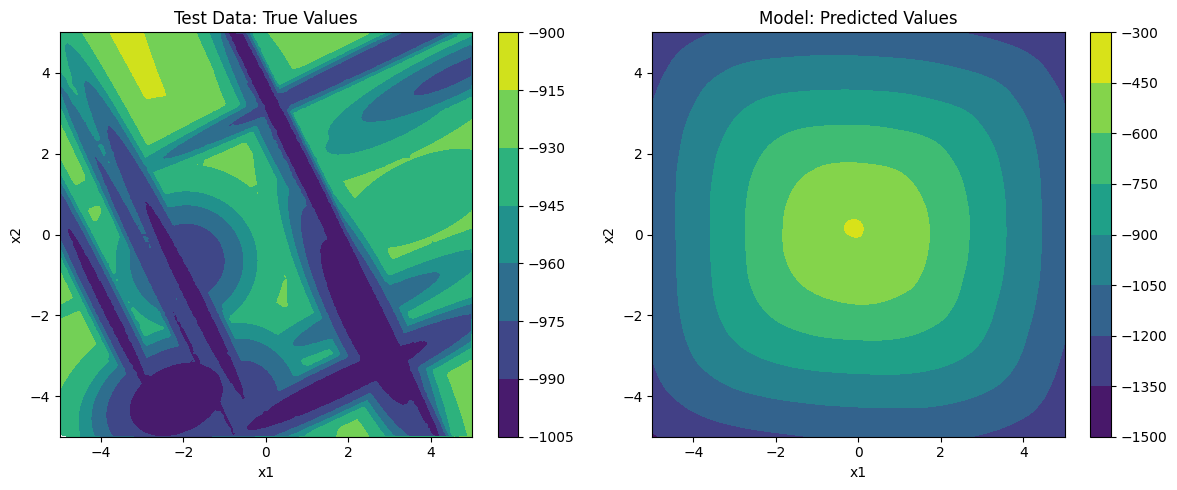

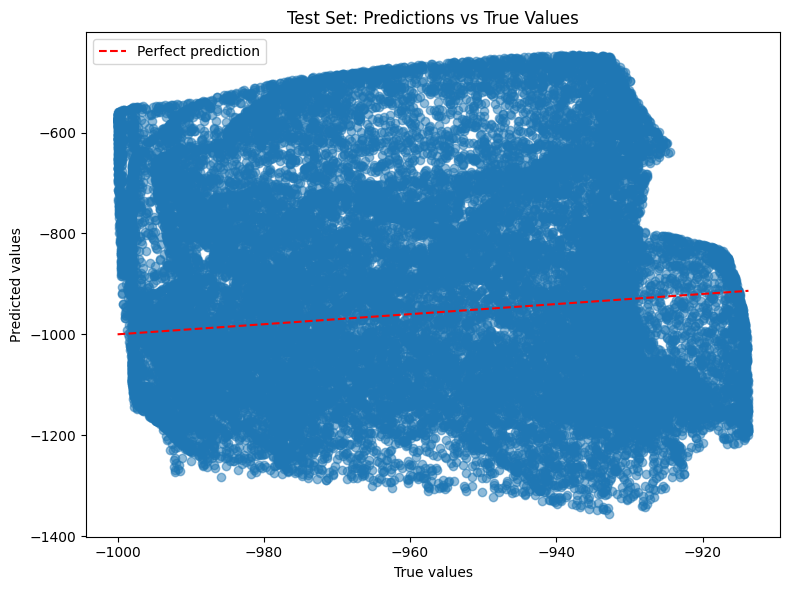

Train set size: 5120
Valid set size: 65280
Test set size: 30208
Epoch 10/100, Train Loss: 77941.4949, Val Loss: 77201.7183
Epoch 20/100, Train Loss: 53858.4774, Val Loss: 52656.6419
Epoch 30/100, Train Loss: 25718.1050, Val Loss: 24413.7070
Epoch 40/100, Train Loss: 6215.7777, Val Loss: 5659.4085
Epoch 50/100, Train Loss: 836.6141, Val Loss: 765.2195
Epoch 60/100, Train Loss: 469.4684, Val Loss: 454.4371
Epoch 70/100, Train Loss: 413.4802, Val Loss: 402.3897
Epoch 80/100, Train Loss: 384.0245, Val Loss: 375.8034
Epoch 90/100, Train Loss: 363.4736, Val Loss: 358.0755
Epoch 100/100, Train Loss: 342.8323, Val Loss: 339.5301
Test Loss (MSE): 339.5829
Test Loss2 (MAE): 15.2090


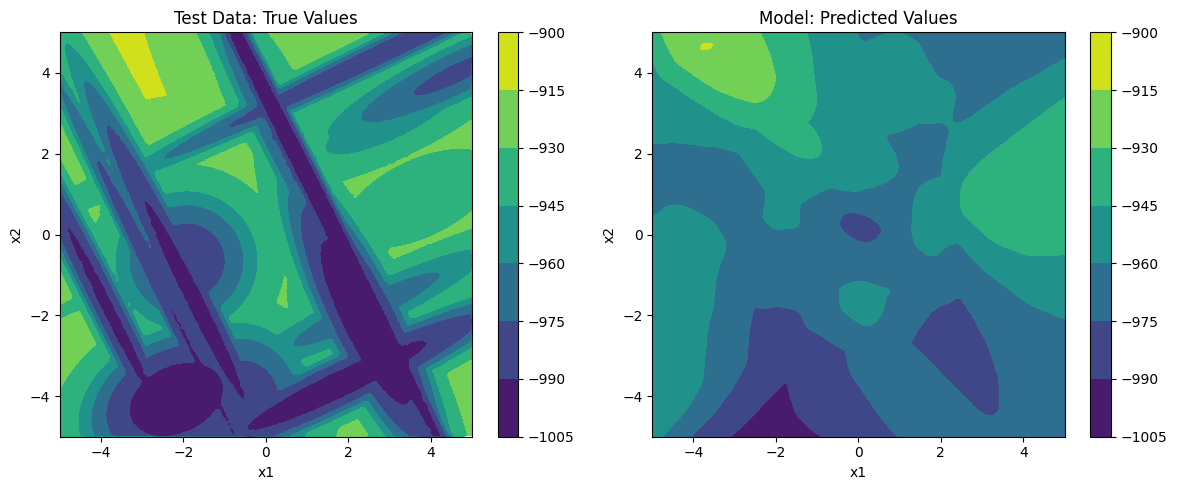

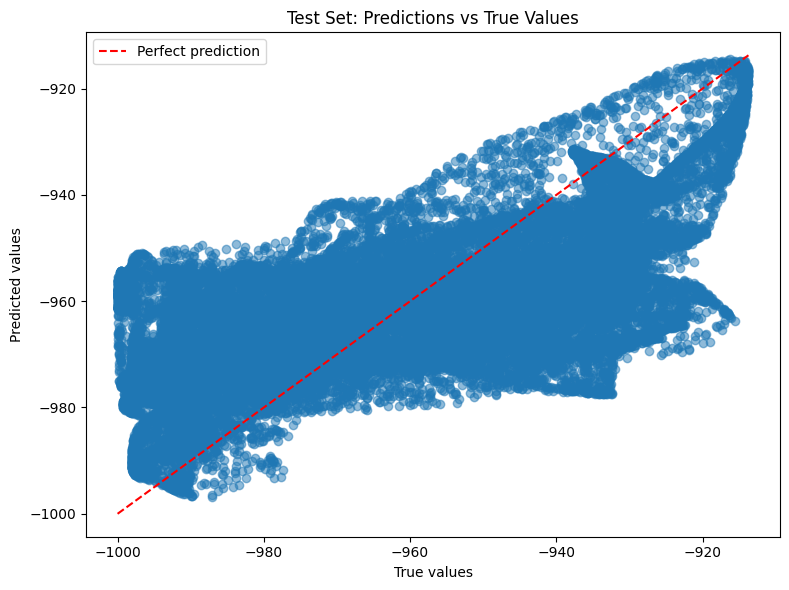

Train set size: 9984
Valid set size: 60160
Test set size: 30208
Epoch 10/100, Train Loss: 55599.6091, Val Loss: 53242.0600
Epoch 20/100, Train Loss: 5345.1296, Val Loss: 4184.8353
Epoch 30/100, Train Loss: 470.8161, Val Loss: 463.9152
Epoch 40/100, Train Loss: 356.7551, Val Loss: 357.7643
Epoch 50/100, Train Loss: 310.8146, Val Loss: 313.6546
Epoch 60/100, Train Loss: 276.0595, Val Loss: 280.9368
Epoch 70/100, Train Loss: 252.1934, Val Loss: 256.6886
Epoch 80/100, Train Loss: 232.9293, Val Loss: 235.8319
Epoch 90/100, Train Loss: 218.7747, Val Loss: 224.0808
Epoch 100/100, Train Loss: 208.9353, Val Loss: 213.0120
Test Loss (MSE): 212.2096
Test Loss2 (MAE): 11.7065


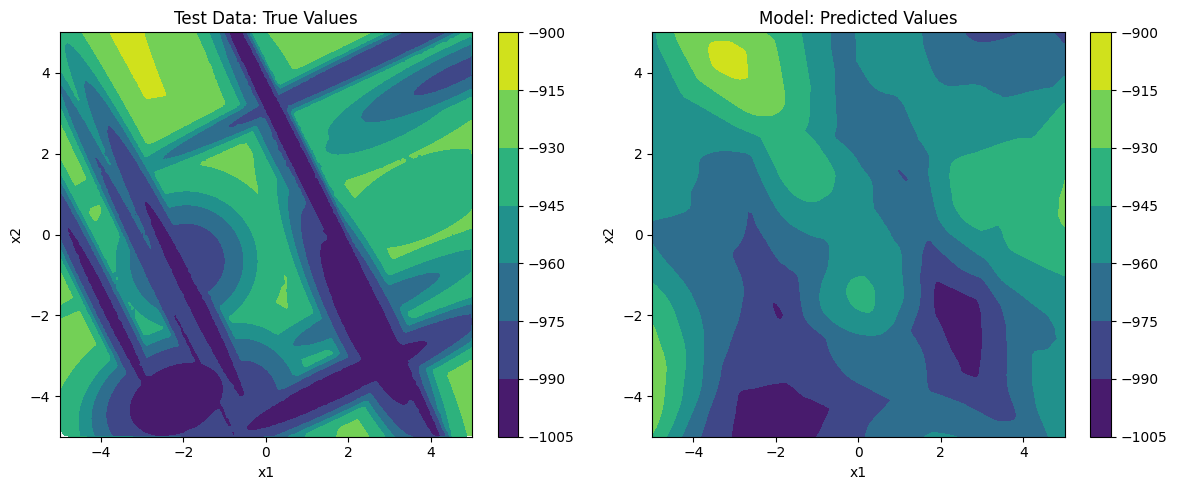

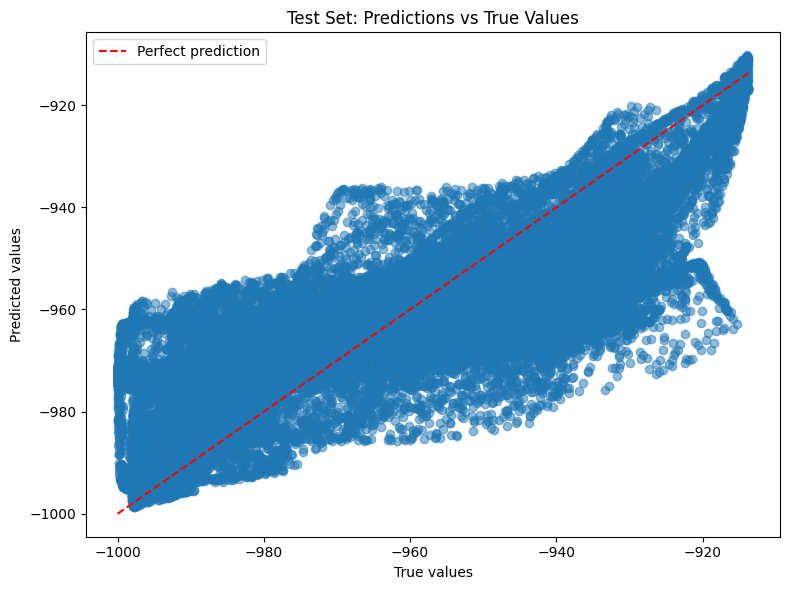

Train set size: 49920
Valid set size: 20480
Test set size: 30208
Epoch 10/100, Train Loss: 471.5213, Val Loss: 466.7593
Epoch 20/100, Train Loss: 337.8316, Val Loss: 334.4028
Epoch 30/100, Train Loss: 235.5871, Val Loss: 234.3271
Epoch 40/100, Train Loss: 184.2748, Val Loss: 183.3443
Epoch 50/100, Train Loss: 162.1948, Val Loss: 165.8292
Epoch 60/100, Train Loss: 146.1940, Val Loss: 145.6782
Epoch 70/100, Train Loss: 134.0138, Val Loss: 133.6446
Epoch 80/100, Train Loss: 121.4725, Val Loss: 128.2016
Epoch 90/100, Train Loss: 117.8852, Val Loss: 116.6780
Epoch 100/100, Train Loss: 112.2545, Val Loss: 133.8701
Test Loss (MSE): 131.0929
Test Loss2 (MAE): 8.5803


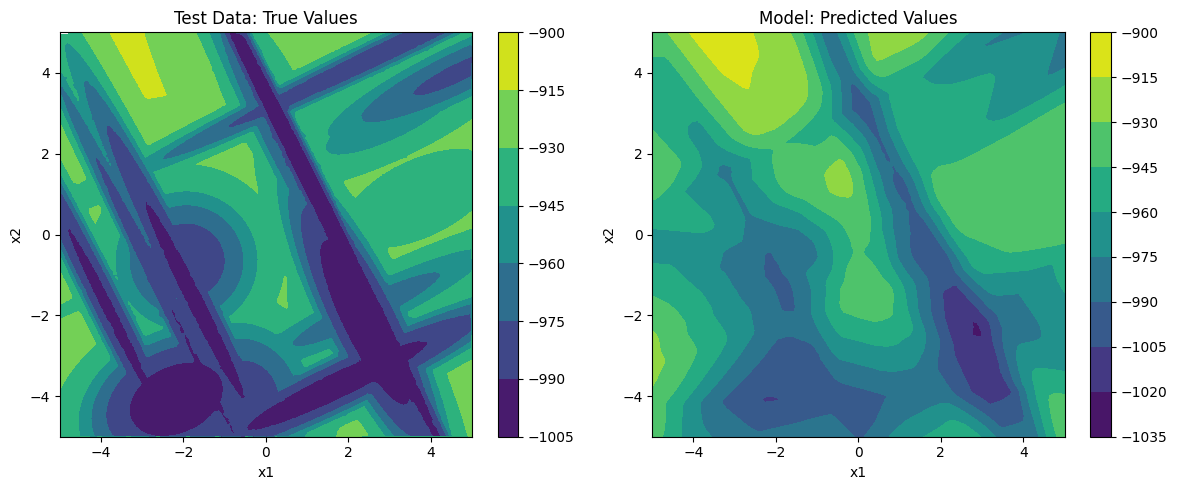

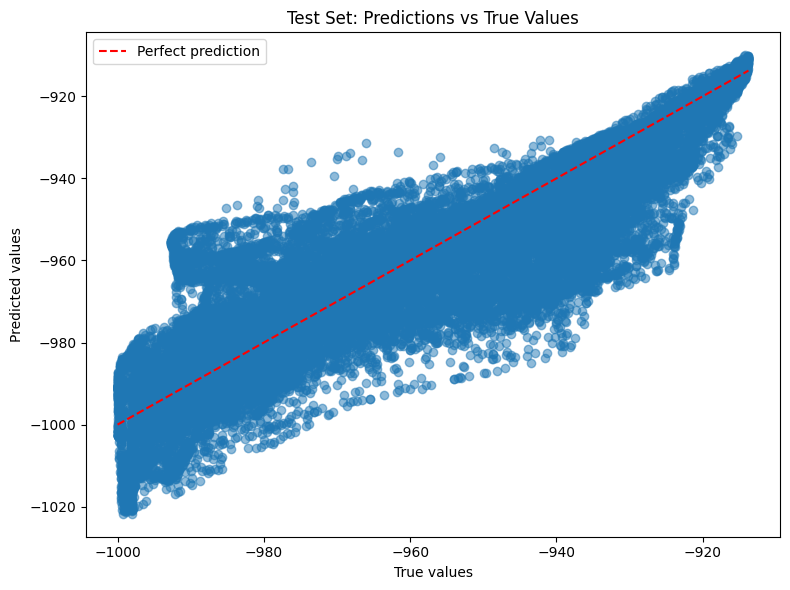

In [17]:
# train_perc + val_perc = 0.7

mse_losses = []
mae_losses = []
training_set_sizes = []

for train_size in train_set_sizes:
    train_perc = train_size / dataset_size

    train_dataloader, val_dataloader, test_dataloader = prepare_dataloaders(
    "./bbob_f022_i01_d02_samples.csv", train_perc=train_perc, val_perc=test_perc - train_perc
    )

    print(f"Train set size: {len(train_dataloader) * 256}")
    print(f"Valid set size: {len(val_dataloader) * 256}")
    print(f"Test set size: {len(test_dataloader) * 256}")
    
    training_set_sizes.append(len(train_dataloader) * 256)
    

    model = MLP().to(device)
    criterion = nn.MSELoss()
    criterion2 = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 100

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        train_loss = train_loss / len(train_dataloader.dataset)
        train_losses.append(train_loss)
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        val_loss = val_loss / len(val_dataloader.dataset)
        val_losses.append(val_loss)
        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
            )

    model.eval()
    test_loss = 0.0
    test_loss2 = 0.0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss2 = criterion2(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            test_loss2 += loss2.item() * inputs.size(0)

    test_loss = test_loss / len(test_dataloader.dataset)
    test_loss2 = test_loss2 / len(test_dataloader.dataset)
    
    mse_losses.append(test_loss)
    mae_losses.append(test_loss2)
    
    print(f"Test Loss (MSE): {test_loss:.4f}")
    print(f"Test Loss2 (MAE): {test_loss2:.4f}")

    plot_contour_comparison(model, test_dataloader, device)
    plot_prediction_scatter(model, test_dataloader, device)

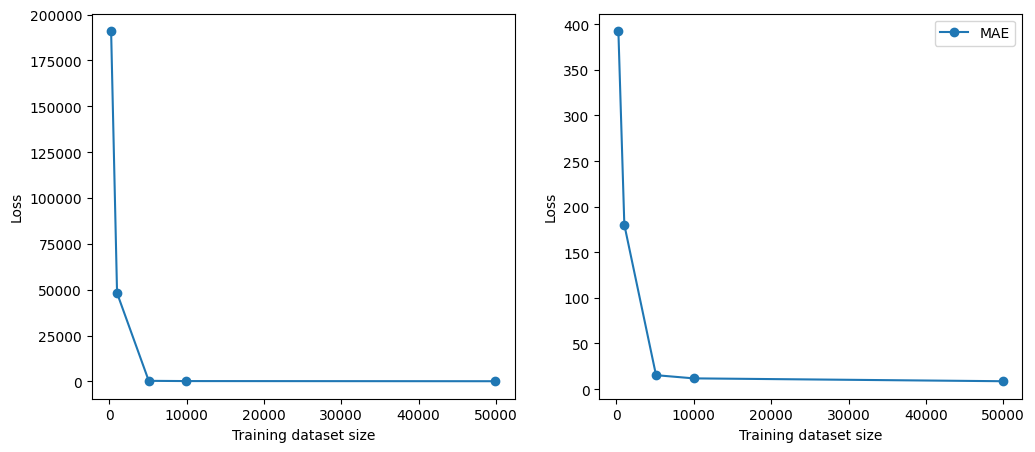

In [25]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(training_set_sizes, mse_losses, label="MSE", marker="o")
ax2.plot(training_set_sizes, mae_losses, label="MAE", marker="o")

ax1.set_xlabel("Training dataset size")
ax1.set_ylabel("Loss")

ax2.set_xlabel("Training dataset size")
ax2.set_ylabel("Loss")

plt.legend()
plt.show()


The bigger the training set size, the better. Although from 10,000 to 50,000, there is not a big difference. I believe that for bigger training datasets we need more epochs. For metrics, I used training loss (it was MSE) and MAE. Both of them showed similar information.


### Exercise 2: Optimization Robustness
- **Task:** Implement the `optimize_model` function to find inputs that minimize the model's output.
- **Instructions:**
  1. Execute the optimization process multiple times (e.g. 10 for each dataset) with different random starting points and record the best surrogate values.
  2. Create a histogram of the best `y` values across all optimization runs to visualize the distribution of results.
  3. Generate a contour plot showing the locations of the solutions found. Analyze the consistency of these solutions.
  4. Use `cocoex` to evaluate the true objective function at the solution points. Compare these values against the surrogate’s predicted values.

### Accessing Original COCO Benchmark Problems

The code below installs and imports the necessary packages to access the original COCO benchmark problems (f1 and f22).
This will allow us to compare our model's predictions with the true functions and evaluate optimization performance.

In [27]:
from cocoex import Suite

function_id = 22  # Switch between 1 and 22 to change the function

suite = Suite(
    "bbob",
    "",
    f"function_indices: {function_id}, dimensions: 2 instance_indices: 1",
)
for function in suite:
    print(function.info)
    print("Function value at (0, 0):", function(np.array([0, 0])))

bbob_f022_i01_d02: a 2-dimensional single-objective problem (problem 315 of suite "b'bbob'" with name "BBOB suite problem f22 instance 1 in 2D")
Function value at (0, 0): -936.0557554469844


In [38]:
x_tab = []
y_tab = []

for _ in range(10):
    output = optimize_model(model=model, num_steps=1000)
    x_tab.append(output[0])
    y_tab.append(output[1])

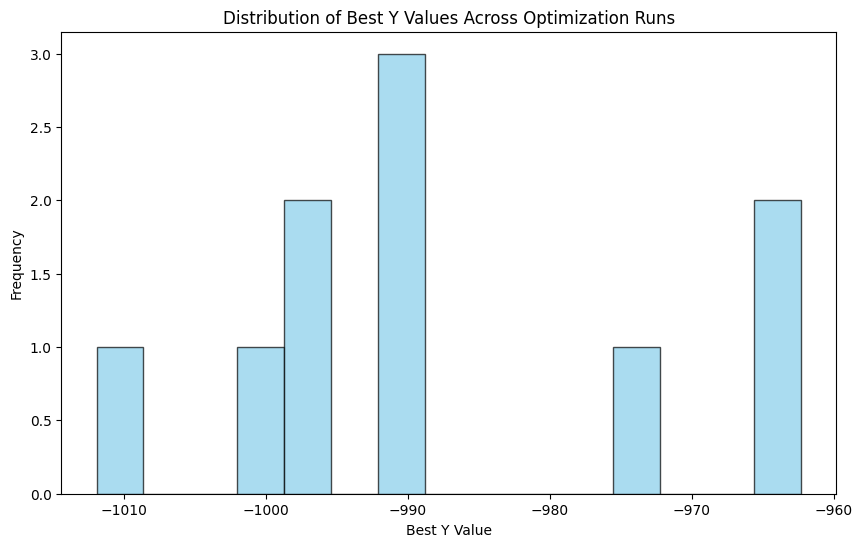

In [39]:
plt.figure(figsize=(10, 6))
plt.hist(y_tab, bins=15, color="skyblue", edgecolor="black", alpha=0.7)
plt.title("Distribution of Best Y Values Across Optimization Runs")
plt.xlabel("Best Y Value")
plt.ylabel("Frequency")

plt.show()

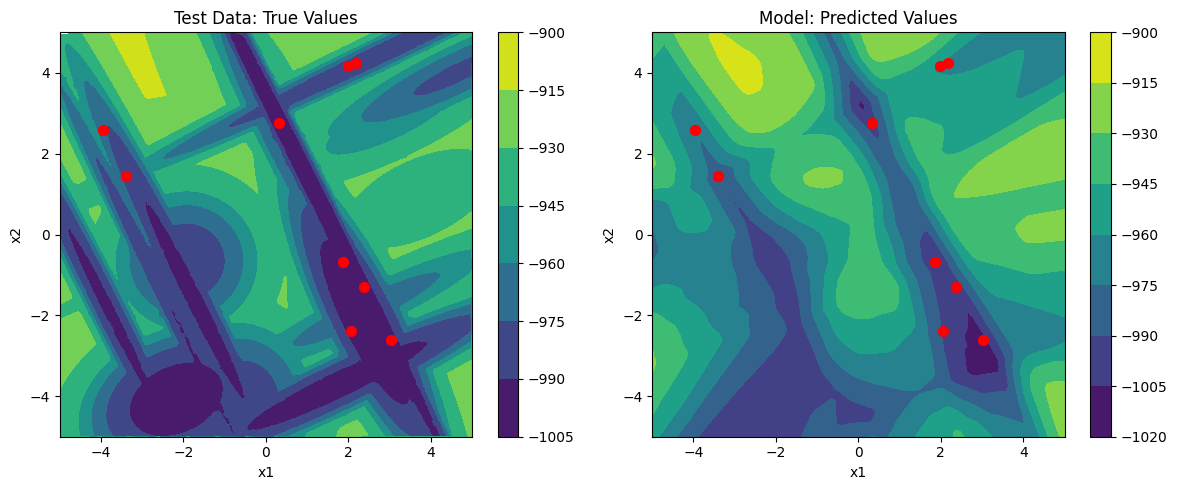

In [54]:
plot_contour_comparison(model, test_dataloader, device, x_tab)

In [63]:
func = suite[0]

for i in range(len(x_tab)):
    x_tensor = x_tab[i]
    x1 = x_tensor[0, 0].item()
    x2 = x_tensor[0, 1].item()
    x_array = x_tensor.cpu().detach().numpy().flatten()
    print(f"For points {x1:.2f}, {x2:.2f} model predicted {y_tab[i]:.2f}. True value is {func(x_array):.2f}. Prediction error: {abs(func(x_array) - y_tab[i]):.2f}")

For points 3.02, -2.60 model predicted -1011.95. True value is -998.34. Prediction error: 13.60
For points -3.39, 1.46 model predicted -990.24. True value is -981.96. Prediction error: 8.28
For points 0.33, 2.76 model predicted -997.65. True value is -999.84. Prediction error: 2.19
For points 1.98, 4.16 model predicted -962.31. True value is -986.54. Prediction error: 24.23
For points -3.95, 2.57 model predicted -974.73. True value is -971.91. Prediction error: 2.82
For points 2.18, 4.25 model predicted -964.14. True value is -986.84. Prediction error: 22.71
For points 2.37, -1.30 model predicted -1001.70. True value is -999.80. Prediction error: 1.89
For points 1.87, -0.67 model predicted -995.71. True value is -997.67. Prediction error: 1.97
For points 2.06, -2.38 model predicted -991.82. True value is -993.80. Prediction error: 1.98
For points -3.39, 1.46 model predicted -990.25. True value is -981.96. Prediction error: 8.28


The obtained points make sense. Most of them are located at fairly low values. If more steps were used, they would probably be even closer to local minima. The most interesting example is the 2 points in the upper right corner. According to the model, they are trapped there and it's difficult to find a better position for them. Among our 10 points, the maximum error made by the model was 24.23. I believe this is a small error. The model approximated our function quite well.